In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import shapely.affinity as aff
import shapely.geometry as geo

import sys
sys.path.append("../")
from electronfactors.ellipse.utilities import (
    shapely_ellipse, _CustomBasinhopping)
from electronfactors.visuals.shape_display import (
    display_shapely, display_stored_cutout)
from electronfactors.visuals.print_generic import (
    print_ellipse)

from electronfactors.visuals.utilities import create_green_cm

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)

rc('legend', fontsize=16)

In [3]:
green_cm = create_green_cm()

In [4]:
def to_eqPonA(width, length):
    ratio = width/length
    eqPonA = 2*(3*(ratio+1) - np.sqrt((3*ratio+1)*(ratio+3))) / width
    
    return eqPonA

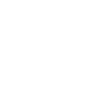

In [12]:
def shapely_aperture(aperture_size):
    bevel = 1.0
    size_at_100 = aperture_size
    pos = size_at_100/2 - bevel
    base_square = geo.Polygon([(-pos, -pos),
                          (pos, -pos),
                          (pos, pos),
                          (-pos, pos)])

    aperture = base_square.buffer(bevel, join_style=3)    
    return aperture

shapely_aperture(10)

In [6]:
def make_to_minimise(width, edge_buffer, aperture_size):
    aperture = shapely_aperture(aperture_size) 
    aperture_erroded = aperture.buffer(-edge_buffer)
    
    def to_minimise(optimiser_input):
        ellipse_input = [
            0, 0, width,
            optimiser_input[0], optimiser_input[1]]
        ellipse = shapely_ellipse(ellipse_input)
        return (100 * ellipse.difference(aperture_erroded).area + 
                aperture_erroded.difference(ellipse).area)
    return to_minimise

def ellipse_in_aperture(width, edge_buffer, aperture_size):

    initial = np.array([aperture_size, 45])
    step_noise = np.array([aperture_size, 30])

    optimiser = _CustomBasinhopping(
        to_minimise=make_to_minimise(width, edge_buffer, aperture_size),
        initial=initial,
        step_noise=step_noise,
        n=3,
        confidence=0.01
    )
    
    length = optimiser.result[0]
    angle = optimiser.result[1]
    
    ellipse_input = [0, 0, width, length, angle]
    ellipse = shapely_ellipse(ellipse_input)

    aperture = shapely_aperture(aperture_size)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    display_shapely(aperture, ax=ax)
    display_shapely(ellipse, ax=ax)    
    plt.show()
    
    return length

In [7]:
def batch_ellipse_in_aperture(width_list, errosion, aperture_size):    
    length_list = [
        ellipse_in_aperture(width, errosion, aperture_size) 
        for width in width_list]    
        
    return np.abs(length_list)

In [8]:
edge_buffer = 0.125
width = dict()
length = dict()
eqPonA = dict()

long_ellipse_width = dict()
long_ellipse_length = dict()

circles = dict()

thin_ellipses_width = dict()
thin_ellipses_length = dict()

short_ellipses_width = dict()
short_ellipses_length = dict()

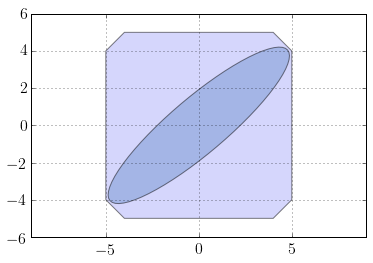

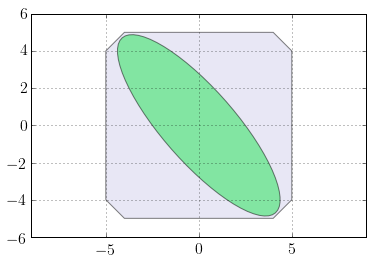

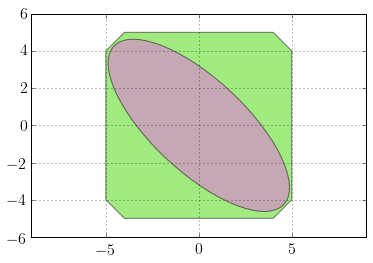

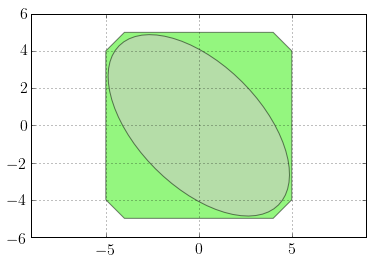

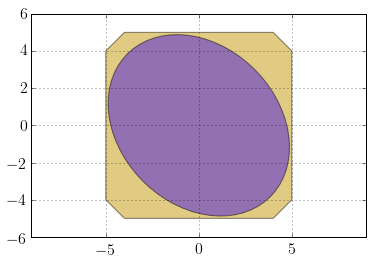

In [9]:
aperture_size = 10
long_ellipse_width[aperture_size] = [3, 3.9, 5, 6.6, 8.5]

long_ellipse_length[aperture_size] = batch_ellipse_in_aperture(
    long_ellipse_width[aperture_size], 
    edge_buffer, aperture_size)

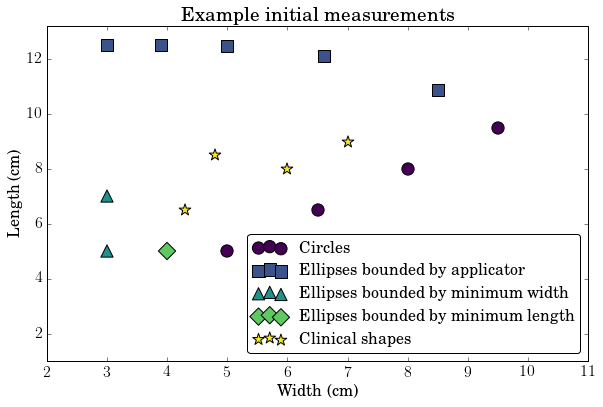

In [10]:
plt.figure(figsize=(6 * 1.618, 6))

circles[aperture_size] = np.array([5, 6.5, 8, 9.5])
plt.scatter(
    circles[aperture_size],
    circles[aperture_size], 
    c=[0.26700401, 0.00487433, 0.32941519], s=150, 
    label='Circles')

aperture_size = 10
plt.scatter(
    long_ellipse_width[aperture_size], 
    long_ellipse_length[aperture_size], s=150, c=green_cm(0.25),
    label='Ellipses bounded by applicator', marker='s')

thin_ellipses_width[aperture_size] = [3]*2
thin_ellipses_length[aperture_size] = [5, 7]
plt.scatter(
    thin_ellipses_width[aperture_size], 
    thin_ellipses_length[aperture_size], c=green_cm(0.5), s=150, 
    label='Ellipses bounded by minimum width', marker='^')

short_ellipses_width[aperture_size] = [4]
short_ellipses_length[aperture_size] = [5]
plt.scatter(
    short_ellipses_width[aperture_size], 
    short_ellipses_length[aperture_size], 
    c=[0.3692142, 0.78888793, 0.38291438], s=150,
    label='Ellipses bounded by minimum length', marker='D')

common_clinical_width = [4.8, 4.3, 7, 6]
common_clinical_length = [8.5, 6.5, 9, 8]
plt.scatter(
    common_clinical_width, 
    common_clinical_length, 
    c=[0.97441665, 0.90358991, 0.13021494], s=150,
    label='Clinical shapes', marker='*')

plt.title(r'Example initial measurements')
plt.xlabel("Width (cm)")
plt.ylabel("Length (cm)")

plt.xlim([2,11])
plt.ylim([1,13.2])

plt.legend(fancybox=True, loc='lower right')

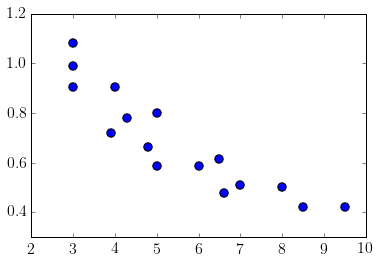

In [11]:
width[aperture_size] = np.concatenate([
    circles[aperture_size], 
    long_ellipse_width[aperture_size], 
    thin_ellipses_width[aperture_size],
    short_ellipses_width[aperture_size],
    common_clinical_width])

length[aperture_size] = np.concatenate([
    circles[aperture_size], 
    long_ellipse_length[aperture_size], 
    thin_ellipses_length[aperture_size],
    short_ellipses_length[aperture_size],
    common_clinical_length])

eqPonA[aperture_size] = to_eqPonA(
    width[aperture_size], length[aperture_size])

# plt.figure(figsize=(6,10))
plt.scatter(width[aperture_size], eqPonA[aperture_size], s=70)